In [ ]:
import numpy as np
import pandas as pd
from reco_systems.filter import filter_df
from reco_systems.user_game_matrix import *
from reco_systems.CF_knn import *
import seaborn as sns
from reco_systems.evaluation import *
from copy import *
from sklearn.metrics import root_mean_squared_error

from surprise import NMF
from surprise import Dataset, accuracy
from surprise.model_selection import cross_validate, train_test_split
from surprise.reader import Reader

from sklearn.metrics import root_mean_squared_error, mean_absolute_error
%load_ext autoreload
%autoreload 2

In [ ]:
# import DB et set min_reviews

folder = "database_cleaned"
avis_clean  = pd.read_csv(f"{folder}/avis_clean.csv", index_col=0)
jeux_clean  = pd.read_csv(f"{folder}/jeux_clean.csv", index_col=0)
users       = pd.read_csv(f"{folder}/users.csv", index_col=0)

min_reviews = 10 # change to set one
rev_filter = filter_df(avis_clean, min_reviews)

11201 10549
2252 2676
1957 2618
1947 2616
1946 2615
1945 2614


In [ ]:
users_count = rev_filter.groupby("User id")["Game id"].count().reset_index().rename(columns={"Game id":"Count"})
slices = [ (10, 50), (50, 100), (100, 200), (200, 1700)]
all_rmse, all_mae, users = [], [], []
np.random.seed(1)

for (mn, mx) in slices:
    users_ids = users_count[(users_count["Count"] >= mn) & (users_count["Count"] < mx)].sample(77, replace=False)["User id"]
    
    users.append(users_ids.values)
    rmse_user, mae_user = [], []
    
    for user in users_ids:
        games_user = rev_filter[rev_filter["User id"] == user].sort_values("Game id")
        games = games_user.sample(int(0.2 * games_user.shape[0]))["Game id"]

        reviews = rev_filter[(rev_filter["User id"] != user) | ((rev_filter["User id"] == user) & (~rev_filter["Game id"].isin(games)))]
        print(reviews.shape)
        model = NMF(n_factors=20, random_state=42, biased=False, reg_pu= 0.1, reg_qi= 0.1)
        data = Dataset.load_from_df(reviews[["User id", "Game id", "Rating"]], reader=Reader(rating_scale=(0, 10)))
        trainset = data.build_full_trainset()
        nmf = model.fit(trainset)

        U = np.array(nmf.pu)  # User-feature matrix (W)
        G = np.array(nmf.qi)  # Item-feature matrix (H)

        games_nnmf_index = np.array([trainset.to_inner_iid(g) for g in np.sort(games)])
        user_nnmf_index = trainset.to_inner_uid(user)
    
        pred_ratings = U[user_nnmf_index] @ G[games_nnmf_index].T
        true_ratings = games_user[games_user["Game id"].isin(games)]["Rating"]

        rmse, mae = root_mean_squared_error(true_ratings, pred_ratings), mean_absolute_error(true_ratings, pred_ratings)
        print(rmse, mae)
        rmse_user.append(rmse)
        mae_user.append(mae)


    all_rmse.append(rmse_user)
    all_mae.append(mae_user)

(96531, 8)
2.308023743434204 2.3061619360662795
(96530, 8)
1.9829389574744702 1.5017179330345387
(96530, 8)
2.5416466360634056 2.2144570363595686
(96530, 8)
3.282093539353043 2.678190464686774
(96530, 8)
1.264345186900427 1.087242254399755
(96531, 8)
3.475677760204229 3.3951921708419395
(96528, 8)
2.2758912124827955 2.1600961907337966
(96531, 8)
1.9486098500831959 1.4106129746019773
(96525, 8)
1.151303932361911 0.8718185025819386
(96530, 8)
4.731558250770518 3.3762538445088572
(96531, 8)
0.7719430005504507 0.7535157768246625
(96531, 8)
2.5342935146328722 2.3772428506075256
(96531, 8)
1.050552818071655 0.980973898057659
(96530, 8)
1.6447345946563956 1.2716673716608045
(96528, 8)
2.6072459666381347 1.9444971128905784
(96531, 8)
1.8763603982493455 1.8613259590592381
(96531, 8)
2.0258501147808623 1.7352176380971
(96531, 8)
0.469349996766281 0.4153643008577763
(96531, 8)
4.017716726747067 3.671257041786437
(96529, 8)
2.3016542028887415 1.8655358364437773
(96529, 8)
1.1816072657946137 0.8610

In [94]:
df = pd.DataFrame(data={"User id":users, "RMSE":all_rmse, "MAE":all_mae})

df['zipped'] = df.apply(lambda row: list(zip(row['User id'], row['RMSE'], row['MAE'])), axis=1)
df_exploded = df.explode('zipped', ignore_index=True)
df_exploded[["User id", "RMSE", "MAE"]] = pd.DataFrame(df_exploded['zipped'].tolist(), index=df_exploded.index)
df_exploded = df_exploded.drop(columns='zipped')
df_exploded["Slices"] = ["(10, 50)"] * 77 + ["(50, 100)"] * 77 + ["(100, 200)"] * 77 +  ["(200, 1700)"] * 77 
df_exploded = df_exploded.melt(id_vars=["User id", "Slices"], value_vars=["RMSE", "MAE"], var_name="Metric", value_name="Value")
df_exploded

,User id,Slices,Metric,Value
0,3524,"(10, 50)",RMSE,2.308024
1,2195,"(10, 50)",RMSE,1.982939
2,1633,"(10, 50)",RMSE,2.541647
3,8018,"(10, 50)",RMSE,3.282094
4,1440,"(10, 50)",RMSE,1.264345
...,...,...,...,...
611,1900,"(200, 1700)",MAE,1.204687
612,161,"(200, 1700)",MAE,1.459556
613,1899,"(200, 1700)",MAE,1.856658
614,2877,"(200, 1700)",MAE,1.615330


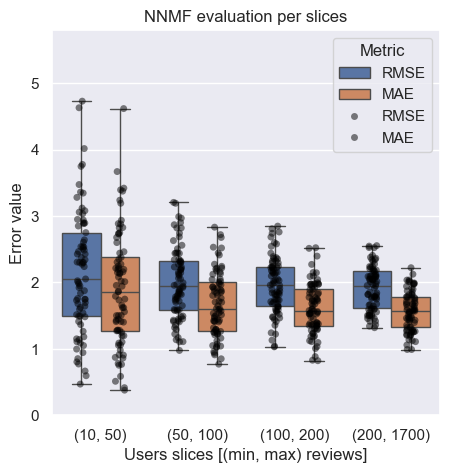

In [96]:
sns.set_theme()
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.boxplot(data=df_exploded, x="Slices", y="Value", hue="Metric", ax=ax, showfliers=False, whis=100)
sns.stripplot(data=df_exploded, x="Slices", y="Value", hue="Metric", ax=ax, jitter=True, dodge=True, palette=["black"] * 2, alpha=0.5)
ax.set_ylim(0, 5.8)
ax.set_title("NNMF evaluation per slices")
ax.set_xlabel("Users slices [(min, max) reviews]")
ax.set_ylabel("Error value")
fig.savefig("images/nnmf_eval.png", dpi=150, format="png")
